In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import os
import mne
from wordfreq import word_frequency
from wordfreq import zipf_frequency
import re
import gc
from sklearn.linear_model import SGDRegressor

from commons import normalize_word

from reader import EXTRACTED_DATA_PATH
from reader import EEG_CHANNEL_COUNT
from reader import MISSING_DATA_SYMBOL
from reader import EEG_FEATURES
from reader import ET_FEATURES

from reader import get_subjects_list

from eeg_plotter import MISSING_CHANNELS
from eeg_plotter import LANGUAGE_CHANNELS
from eeg_plotter import TRT_RANGES

from eeg_plotter import device_channel_to_data_channel
from eeg_plotter import channel_fill
from eeg_plotter import eeg_data_pad_to_len
from eeg_plotter import get_evoked_for_eeg_data
from eeg_plotter import get_raw_word_eeg
from eeg_plotter import get_raw_word_eeg_mean

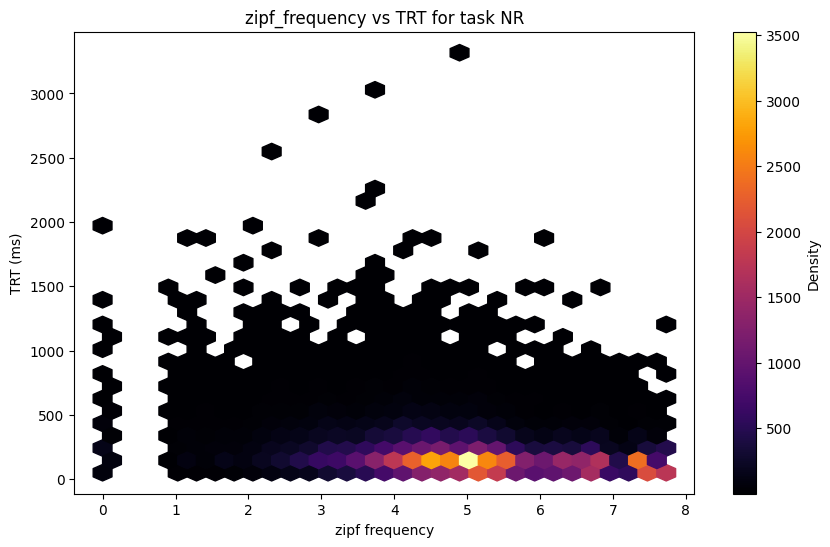

In [9]:
# compute a graph  showing the relationship between TRT and zipf_frequency
task = 'NR'

data_df = pd.read_csv(f'{EXTRACTED_DATA_PATH}extracted_data_{task}/data.tsv', sep='\t', keep_default_na=False, na_values=[''])
data_df['TRT'] = data_df['TRT'].astype(float)

data_df['zipf_freq'] = data_df['content'].apply(lambda word : zipf_frequency(word, 'en'))

plt.figure(figsize=(10, 6))
plt.hexbin(data_df['zipf_freq'], data_df['TRT'], gridsize=30, cmap='inferno', mincnt=1)
plt.colorbar(label='Density')
plt.xlabel('zipf frequency')
plt.ylabel('TRT (ms)')
plt.title(f'zipf_frequency vs TRT for task {task}')
plt.show()

In [49]:
# train a regression model to predict the zipf frequency of words

def in_out_data_generator_mean(data_df, channels=[c for c in range(1, 129) if c not in MISSING_CHANNELS], time=1000, window_size=50): # TODO freq
    '''
    data_df: must contain at least these columns: 'task', 'subject', 'content', 'sentence_id', 'word_idx'
    channels: device channels to use (channels in MISSING_CHANNELS will be ignored)
    time: time interval to take into account, in miliseconds
    window_size: window size over which averaging is done, in miliseconds
    '''
    if time % window_size != 0:
        time -= time%window_size
    data_df = data_df[ ['task', 'subject', 'content', 'sentence_id', 'word_idx'] ]
    channels = [device_channel_to_data_channel(c) for c in channels if c not in MISSING_CHANNELS]
    for row in data_df.itertuples(index=False):
        task, subject, word, sent_id, word_idx = row
        eeg_data_path = f'{EXTRACTED_DATA_PATH}extracted_data_{task}/eeg_data/{subject}/{sent_id}/word_{word_idx}_raw.tsv'
        if not os.path.exists(eeg_data_path):
            continue
        eeg_data = pd.read_csv(eeg_data_path, sep='\t', usecols=lambda col: col!='sentence_relative_fix_idx').to_numpy()
        channels_data = eeg_data[:min(time, len(eeg_data)), channels]
        x = np.zeros((1, time//window_size, len(channels)), dtype=np.float64)
        for i in range(len(channels_data)//window_size):
            x[0][i]=np.mean(channels_data[i*window_size:min(len(channels_data), (i+1)*window_size), :], axis=0)
        x = x.reshape(1, (time//window_size)*len(channels))
        y = np.array([zipf_frequency(word, 'en')], dtype=np.float64)
        yield (x, y)

model = SGDRegressor()
task = 'NR'
channels = [51]


full_df = pd.read_csv(f'{EXTRACTED_DATA_PATH}extracted_data_{task}/data.tsv', sep='\t', keep_default_na=False, na_values=[''])

# very lazy 80/20 train-test split
is_test_row = [i%5==0 for i in range(len(full_df))]
is_train_row = [not b for b in is_test_row] 

train_df = full_df[ is_train_row ]
test_df = full_df[ is_test_row ]

for x, y in in_out_data_generator_mean(train_df, channels):
    model.partial_fit(x, y)

print('Finished training')

test_x = []
test_y = []
sse = 0 # sum of squared errors
sae = 0 # sum of absolute errors
sep = 0 # sum of error percentages (excluding 0s)
n0yc = 0 # non-0 y count
for x, y, in in_out_data_generator_mean(test_df, channels):
    test_x.append(x[0])
    test_y.append(y)
    prediction = model.predict(x)
    sse += (prediction[0]-y[0])**2
    sae += abs( y[0]-prediction[0] )
    if y[0]!=0:
        sep += abs( (y[0]-prediction[0]) / y[0]) * 100
        n0yc+=1

print(f'Average absolute error: {sae / len(test_x)}')
print(f'Average squared error: {sse / len(test_x)}')
print(f'Average error percentage: {sep / n0yc}')
print(f'Sklearn score: {model.score(test_x, test_y)}')


Finished training
Average absolute error: 1.1351943177014856
Average squared error: 2.108388065930831
Average error percentage: 25.543353432872063
Sklearn score: -0.01823431260639863


In [44]:
# print a random prediction-actual frequency pair
for x, y in in_out_data_generator_mean(full_df.sample(), channels):
    print(f'Model prediction: {model.predict(x)}')
    print(f'Actual frequency: {y}')

Model prediction: [4.8380996]
Actual frequency: [4.45]


In [51]:
# TODO freq check
task = 'TSR'
full_df = pd.read_csv(f'{EXTRACTED_DATA_PATH}extracted_data_{task}/data.tsv', sep='\t', keep_default_na=False, na_values=[''])
full_df = full_df[ ['task', 'subject', 'sentence_id', 'word_idx', 'TRT'] ]
trt_to_samples_ratio = 0
valid_eegs_count = 0
for row in full_df.itertuples(index = False):
    task, subject, sent_id, word_idx, trt = row
    eeg_data_path = f'{EXTRACTED_DATA_PATH}extracted_data_{task}/eeg_data/{subject}/{sent_id}/word_{word_idx}_raw.tsv'
    if not os.path.exists(eeg_data_path):
        continue
    eeg_data = pd.read_csv(eeg_data_path, sep='\t', usecols=lambda col: col!='sentence_relative_fix_idx').to_numpy()
    trt_to_samples_ratio += trt / len(eeg_data)
    valid_eegs_count += 1
trt_to_samples_ratio /= valid_eegs_count
print(f'Average TRT to sample count ratio: {trt_to_samples_ratio}')

Average TRT to sample count ratio: 0.9925087250307896
